In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
import imblearn
from imblearn.over_sampling import RandomOverSampler

In [72]:
df = pd.read_pickle("./data/vel_LR_ssh.pkl")

In [73]:
df["faults"].explode().value_counts()

Machine_Misalignment.                                            199
Machine_Bearings_Loosness_and/or_Excessive_Clearance_Problem.    104
Machine_Bearings_Fault.                                           70
Motor_Bearings_Fault.                                             68
Structural_Looseness.                                             63
Pump_Flow_Problem.                                                58
Motor_Bearings_Loosness_and/or_Excessive_Clearance_Problem.       51
Machine_Coupling_Problem.                                         50
Machine_Bearings_Lubrication_Problem.                             47
Fan_Flow_Problem.                                                 32
Machine_Unbalance.                                                24
Machine_Bearings_Wear_Problem.                                    19
Motor_Bearings_Lubrication_Problem.                               18
Machine_Severe_Misalignment.                                      17
Motor_Electrical_Problem.         

In [74]:
# Include the name of the fault when it's in the machine and when it's in the motor
machine_fault_names = ["Machine_Bearings_Loosness_and/or_Excessive_Clearance_Problem."]
motor_fault_names = ["Motor_Bearings_Loosness_and/or_Excessive_Clearance_Problem."]

In [75]:
# Filter the dataframe and create a new one with the time series, and the label of the motor fault and machine fault.
faults_df = pd.DataFrame()
faults_df["time series"] = df["ts"]
faults_df["motor bearing"] = df["faults"].apply(
    lambda x: 1 if any(fault in x for fault in motor_fault_names) else 0
)
faults_df["machine bearing"] = df["faults"].apply(
    lambda x: 1 if any(fault in x for fault in machine_fault_names) else 0
)
faults_df

,time series,motor bearing,machine bearing
0,"[[-0.000182507, -0.000762011, -0.00155276, -0....",0,0
1,"[[-0.004772555, -0.004103458, -0.003247749, -0...",0,0
2,"[[-0.002188359, -0.002100263, -0.001989596, -0...",0,0
3,"[[-0.000954767, -0.001490966, -0.001977236, -0...",0,0
4,"[[-0.002692016, -0.002709083, -0.001516245, -0...",0,0
...,...,...,...
227,"[[0.000500389, 0.00026631, -6.22153e-05, -0.00...",1,1
228,"[[0.004057665, 0.004089431, 0.003451477, 0.001...",0,0
229,"[[-0.001631388, -0.000988903, -0.000203718, 0....",0,0
230,"[[0.006781348, 0.00627183, 0.005341785, 0.0048...",0,0


In [76]:
# Convert the time series and labels into lists for further processing.
ts_list = faults_df["time series"].to_list()
labels_list = faults_df.apply(
    lambda row: [row["motor bearing"], row["machine bearing"]], axis=1
)

In [77]:
# Separate the motor and machines time series.
split_ts_list = list()
split_labels_list = list()


for index, ts in enumerate(ts_list):
    label = labels_list[index]

    motor_ts = ts[:6, :]
    machine_ts = ts[6:, :]

    split_ts_list.append(motor_ts)
    split_ts_list.append(machine_ts)

    if label == [0, 0]:  # No looseness in the motor or in the machine
        split_labels_list.append(0)
        split_labels_list.append(0)

    elif label == [1, 0]:  # Looseness in the motor only
        split_labels_list.append(1)
        split_labels_list.append(0)

    elif label == [0, 1]:  # Looseness in the machine only
        split_labels_list.append(0)
        split_labels_list.append(1)

    else:  # Looseness in both
        split_labels_list.append(1)
        split_labels_list.append(1)

len(split_ts_list), len(split_labels_list), split_ts_list[0].shape
# Notice that the number of time series is now doubled (since we separated the singals of the motor and machine)

(464, 464, (6, 4096))

In [78]:
def getWindowedData(ts, label, window_length=256, overlap=0.1):
    """Will return an array of shape (Number of windows x Number of channels x Length)
    The overlap value here is a percentage, i.e. for a value of 0.1, each two successive time series will 10% common values
    For no overlap, set overlap = 0 when calling the function"""

    ts_no_nans = ts[
        :, ~np.any(np.isnan(ts), axis=0)
    ]  # Index the time series to remove NaNs

    step_size = int(window_length * (1 - overlap))

    windowed_ts_list = list()
    windowed_labels = []

    for i in range(0, ts_no_nans.shape[1] - window_length + 1, step_size):
        start_index = i
        end_index = i + window_length
        windowed_ts_list.append(ts_no_nans[:, start_index:end_index])
        windowed_labels.append(label)

    windowed_ts_array = np.array(windowed_ts_list)
    windowed_labels = np.array(windowed_labels)

    return windowed_ts_array, windowed_labels

In [79]:
# Define windowing parameters
window_length = 1024
overlap = 0

In [80]:
"""
Split the data into train and test before training to make sure the windows of the same time series do not get into training and testing simultaneously
"""

from sklearn.model_selection import train_test_split

sample_indices = list(range(len(split_ts_list)))
train_sample_indices, test_sample_indices = train_test_split(
    sample_indices, test_size=0.2, shuffle=True
)

X_train = []
y_train = []
X_test = []
y_test = []

for index in train_sample_indices:
    ts = split_ts_list[index]
    label = split_labels_list[index]
    data_pairs = getWindowedData(
        ts, label=label, window_length=window_length, overlap=overlap
    )
    X_train.append(data_pairs[0])
    y_train.append(data_pairs[1])

for index in test_sample_indices:
    ts = split_ts_list[index]
    label = split_labels_list[index]
    data_pairs = getWindowedData(
        ts, label=label, window_length=window_length, overlap=overlap
    )
    X_test.append(data_pairs[0])
    y_test.append(data_pairs[1])

X_train_arr = np.concatenate(X_train, axis=0)
y_train_arr = np.concatenate(y_train, axis=0)
X_test_arr = np.concatenate(X_test, axis=0)
y_test_arr = np.concatenate(y_test, axis=0)

In [81]:
class FaultClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FaultClassifier, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

Now we start working with the FFT data instead of time series to see the huge difference in both. Here we use undersampling too.

In [82]:
def GetFFT(ts):
    return np.abs(np.fft.rfft(ts * np.hanning(len(ts))))[:-1] * 2

In [83]:
minority_class = 1  # Change this if your minority class label is different

# Find indices of minority and majority class samples
minority_indices = np.where(y_train_arr == minority_class)[0]
majority_indices = np.where(y_train_arr != minority_class)[0]

# Count the number of samples in each class
minority_count = len(minority_indices)
majority_count = len(majority_indices)

# Calculate the number of samples to remove from the majority class
samples_to_remove = majority_count - minority_count

# Randomly select samples to remove from the majority class
samples_to_remove_indices = np.random.choice(
    majority_indices, size=samples_to_remove, replace=False
)

# Remove selected samples from X_train_arr and y_train_arr
X_train_arr = np.delete(X_train_arr, samples_to_remove_indices, axis=0)
y_train_arr = np.delete(y_train_arr, samples_to_remove_indices)

* Uncomment the next cell to do over sampling , but don't forget to comment out the above undersampling  cell

In [84]:
# oversampler=imblearn.over_sampling.RandomOverSampler(sampling_strategy='minority')
# x_shape=X_train_arr.shape
# y_shape=y_train_arr.shape

# X_train_arr,y_train_arr=oversampler.fit_resample(X_train_arr.reshape(X_train_arr.shape[0],-1),y_train_arr.reshape(y_train_arr.shape[0],-1))

# X_train_arr=X_train_arr.reshape(-1,x_shape[1],x_shape[2])

In [85]:
X_train_fft_arr = list()
X_test_fft_arr = list()

for bearing_channels in X_train_arr:
    temp_fft_arr = []
    for channel in bearing_channels:
        temp_fft_arr.append(GetFFT(channel))

    X_train_fft_arr.append(temp_fft_arr)

for bearing_channels in X_test_arr:
    temp_fft_arr = []
    for channel in bearing_channels:
        temp_fft_arr.append(GetFFT(channel))

    X_test_fft_arr.append(temp_fft_arr)


X_train_fft_arr = np.array(X_train_fft_arr)
X_test_fft_arr = np.array(X_test_fft_arr)

# Choose from Normalization or Standardization

* Normalization

In [86]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# X_train_normalized = scaler.fit_transform(X_train_fft_arr.reshape(X_train_fft_arr.shape[0],-1)).reshape(X_train_fft_arr.shape)
# X_test_normalized = scaler.transform(X_test_fft_arr.reshape(X_test_fft_arr.shape[0],-1)).reshape(X_test_fft_arr.shape)

* Standardization

In [87]:
num_samples, num_channels, num_features = X_train_fft_arr.shape
X_train_reshaped = X_train_fft_arr.reshape((num_samples, num_channels * num_features))

# Compute mean and standard deviation for each sample
mean_per_sample = np.mean(X_train_reshaped, axis=1, keepdims=True)
std_per_sample = np.std(X_train_reshaped, axis=1, keepdims=True)

# Apply z-score normalization for each sample
X_train_normalized_reshaped = (X_train_reshaped - mean_per_sample) / std_per_sample

# Reshape the normalized array back to the original shape
X_train_normalized = X_train_normalized_reshaped.reshape(
    (num_samples, num_channels, num_features)
)

X_train_normalized.shape  # It has the same shape as X_train_arr
# Do the same for the test set
num_samples, num_channels, num_features = X_test_fft_arr.shape
X_test_reshaped = X_test_fft_arr.reshape((num_samples, num_channels * num_features))

mean_per_sample = np.mean(X_test_reshaped, axis=1, keepdims=True)
std_per_sample = np.std(X_test_reshaped, axis=1, keepdims=True)

X_test_normalized_reshaped = (X_test_reshaped - mean_per_sample) / std_per_sample

X_test_normalized = X_test_normalized_reshaped.reshape(
    (num_samples, num_channels, num_features)
)

X_test_normalized.shape

(452, 6, 512)

* why is this size changing

In [88]:
y_train_arr.size

952

In [89]:
X_train_tensor = torch.tensor(X_train_normalized, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_arr, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_normalized, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_arr, dtype=torch.float32)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [90]:
input_size = (
    6 * window_length // 2
)  # Input size is now halved because the FFT contains half the number of points in the time series
hidden_size = 35
output_size = 1

In [91]:
model = FaultClassifier(input_size, hidden_size, output_size)

# weihted loss equation=total no. off samples /(no. of class samlpe * no. of classes)
# criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(1.2234982332155477))

# normal loss function
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 1/50, Loss: 0.320945143699646
Epoch [1/50], Loss: 0.3209, Train Acc: 0.8782, Test Acc: 0.7566
Epoch 2/50, Loss: 0.2814820408821106
Epoch [2/50], Loss: 0.2815, Train Acc: 0.9433, Test Acc: 0.8429
Epoch 3/50, Loss: 0.12011747807264328
Epoch [3/50], Loss: 0.1201, Train Acc: 0.9496, Test Acc: 0.8739
Epoch 4/50, Loss: 0.12208011746406555
Epoch [4/50], Loss: 0.1221, Train Acc: 0.9884, Test Acc: 0.8496
Epoch 5/50, Loss: 0.052783552557229996
Epoch [5/50], Loss: 0.0528, Train Acc: 0.9937, Test Acc: 0.8451
Epoch 6/50, Loss: 0.018744410946965218
Epoch [6/50], Loss: 0.0187, Train Acc: 0.9937, Test Acc: 0.8562
Epoch 7/50, Loss: 0.05407595634460449
Epoch [7/50], Loss: 0.0541, Train Acc: 0.9958, Test Acc: 0.8673
Epoch 8/50, Loss: 0.04451136291027069
Epoch [8/50], Loss: 0.0445, Train Acc: 0.9979, Test Acc: 0.8650
Epoch 9/50, Loss: 0.02143385075032711
Epoch [9/50], Loss: 0.0214, Train Acc: 0.9979, Test Acc: 0.8540
Epoch 10/50, Loss: 0.009940167888998985
Epoch [10/50], Loss: 0.0099, Train Acc: 0.9

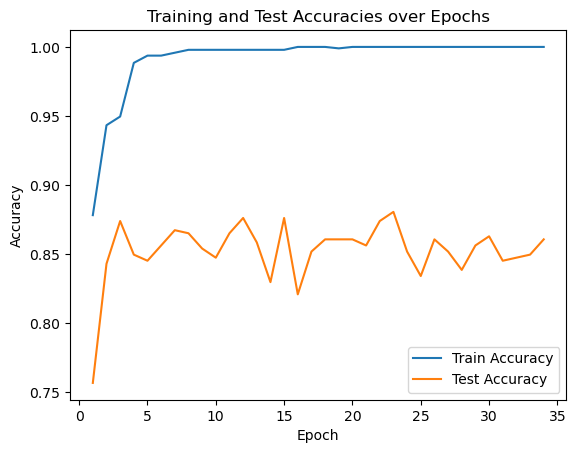

In [92]:
train_accuracies = []
test_accuracies = []

num_epochs = 50

early_stopping_patience = (
    10  # Number of epochs with no improvement after which training will be stopped
)


best_test_accuracy = 0.0
best_epoch = 0

for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

    model.eval()

    with torch.no_grad():
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            outputs = model(inputs)
            predicted_train = (outputs > 0.5).float()
            total_train += labels.size(0)
            correct_train += (predicted_train == labels.view(-1, 1)).sum().item()

        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

    with torch.no_grad():
        correct_test = 0
        total_test = 0
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predicted_test = (outputs > 0.5).float()
            total_test += labels.size(0)
            correct_test += (predicted_test == labels.view(-1, 1)).sum().item()

        test_accuracy = correct_test / total_test
        test_accuracies.append(test_accuracy)

    print(
        f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}"
    )

    # Check for early stopping
    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        best_epoch = epoch + 1
        # Save the model checkpoint if it has the best test accuracy
        torch.save(model.state_dict(), "best_model.pth")
    elif epoch - best_epoch >= early_stopping_patience:
        print(
            f"Early stopping at epoch {epoch+1} as there is no improvement in test accuracy for the last {early_stopping_patience} epochs."
        )
        break

# Visualize the learning curves
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Test Accuracies over Epochs")
plt.legend()
plt.show()

Test Accuracy: 0.8805
Metrics for Positive Class:
Precision: 0.6385
Recall: 0.9222
F1 Score: 0.7545
Metrics for Negative Class:
Precision: 0.9783
Recall: 0.8702
F1 Score: 0.9211


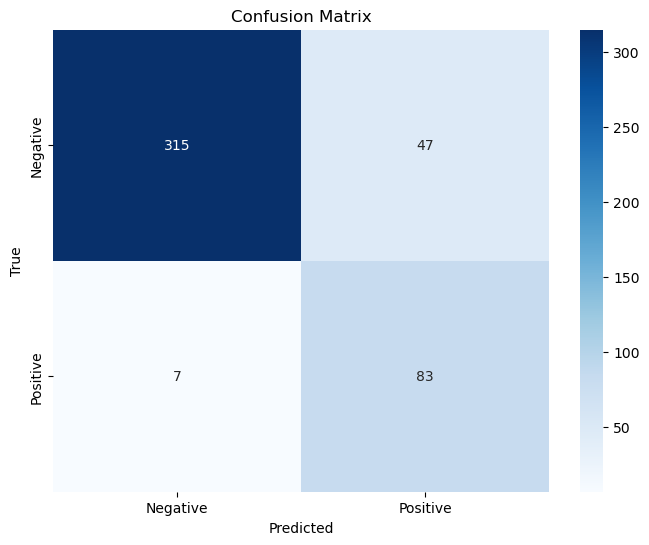

In [93]:
best_model = FaultClassifier(input_size, hidden_size, output_size)
best_model.load_state_dict(torch.load("best_model.pth"))
best_model.eval()

# Evaluation
with torch.no_grad():
    correct_test = 0
    total_test = 0
    all_predicted = []
    all_labels = []
    for inputs, labels in test_loader:
        outputs = best_model(inputs)  # Use the best model for evaluation
        predicted_test = (outputs > 0.5).float()
        total_test += labels.size(0)
        correct_test += (predicted_test == labels.view(-1, 1)).sum().item()

        all_predicted.extend(predicted_test.cpu().numpy())
        all_labels.extend(labels.view(-1, 1).cpu().numpy())

test_accuracy = correct_test / total_test
precision_positive = precision_score(all_labels, all_predicted, pos_label=1)
recall_positive = recall_score(all_labels, all_predicted, pos_label=1)
f1_positive = f1_score(all_labels, all_predicted, pos_label=1)

precision_negative = precision_score(all_labels, all_predicted, pos_label=0)
recall_negative = recall_score(all_labels, all_predicted, pos_label=0)
f1_negative = f1_score(all_labels, all_predicted, pos_label=0)

print(f"Test Accuracy: {test_accuracy:.4f}")
print("Metrics for Positive Class:")
print(f"Precision: {precision_positive:.4f}")
print(f"Recall: {recall_positive:.4f}")
print(f"F1 Score: {f1_positive:.4f}")

print("Metrics for Negative Class:")
print(f"Precision: {precision_negative:.4f}")
print(f"Recall: {recall_negative:.4f}")
print(f"F1 Score: {f1_negative:.4f}")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_predicted)
# print('Confusion Matrix:')
# print(cm)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Negative", "Positive"],
    yticklabels=["Negative", "Positive"],
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()